# Title: Effects of Atlantic Niño on Hurricane Genesis Potential

## Questions:
    What is the relationship between Atlantic Niño and Hurricane genesis?
    
    Bjerkness feedback and hurricane generation?
    
    Is there an effect of model biases on this relationship, specifically CMIP and E3M?
    
    Do the large ensembles correlate with reanalysis correlations?
    
    (future work?) Are future changes in Bjerkness feedback and atmosphere ocean decoupling causing changes in hurricane genesis potential?
    
    (future work) 


<h1>Notes:</h1>
    Atlantic Niño (AN) is a seasonal phenomenon which during its positive phase raises SSTs in the eastern equatorial Atlantic near the African coasts, relaxes trade winds, and weakens east-west SST gradient (Fasullo et al X).   
   

# Tasks and required I/O

## Task 1: Reanalysis Time series

IN: HadiSST Netcdf

OUT: Time series of average SST in the box. from 3S to 3N 0W to 20W

## Task 2: Reanalysis Atlantic Niño index

IN: SST dataframe

OUT: Weighted average based anomaly time series

## Task 3: Atlantic Niño JJA Composite maps

IN: Atlantic Niño index dataframe

OUT: JJA area weighted mean anomaly 20S to 20N and 100W to 20E

# Necessary Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.util as cutil
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import metpy
import cftime
from geocat.viz import util as gvutil
import warnings
# from geocat.viz import cmaps as gvcmaps
# import tcpypi must upload package

# Useful Functions

In [3]:
def ATLN_box(ds, box=None):
    if box == None:
        # Bounding Box in degN and degE
        north = 3
        south = -3
        east = 360
        west = 340
        lons = slice(west, east)
    else:
        # custom bounding box
        west, east, south, north = box
    t_i = cftime.DatetimeNoLeap(1958, 1, 15)
    t_f = cftime.DatetimeNoLeap(2019, 12, 31)
    corrected=False
    if west < 0:
        west += 360
        corrected=True
    if east < 0:
        east += 360
        corrected=True
    if east < west:
        ds = ds.where(((ds.lon > west) | (ds.lon < east)))
    if south < 0:
        ds = ds.where(((ds.lat > south) | (ds.lat < north)))
    
    if corrected==True:
        return ds.sel(time=slice(t_i, t_f))
    else:
        return ds.sel(lat=slice(south, north), lon=slice(west, east), time=slice(t_i, t_f))

def AN_map(ds_to_plt, bounds, name):
    fig, ax = plt.subplots(1, 1, figsize=(10,5),
                           subplot_kw={'projection': ccrs.PlateCarree()})
    fig.subplots_adjust(hspace=0, wspace=0, top=0.925, left=0.1)
    cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])
    cdat, clon = cutil.add_cyclic_point(ds_to_plt, ds_to_plt.lon)

    ax.set_title(name)
    lon_ticks = np.arange(bounds[0], bounds[1], 20)
    lat_ticks = np.arange(bounds[2], bounds[3], 10)
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.add_feature(cf.LAND)
    
    
    def resize_colobar(event):
        plt.draw()

        posn = ax.get_position()
        cbar_ax.set_position([posn.x0 + posn.width + 0.01, posn.y0,
                              0.04, posn.height])
    
    ax.set_extent(bounds, ccrs.PlateCarree())
    sst_contour = ax.contourf(clon, ds_to_plt.lat, cdat, levels=20, transform=ccrs.PlateCarree(), cmap='YlOrBr')
    fig.canvas.mpl_connect('resize_event', resize_colobar)
    ax.coastlines()
    plt.colorbar(sst_contour, cax=cbar_ax)
    
    resize_colobar(None)
    plt.show()

# HadiSST Atlantic Niño index

## Data Import

In [4]:
# import data into xarray
ds = xr.open_dataset('Data/hadisst.187001-201912.nc') 
# print(ds.keys())
sst = ds.sst
ds.close()

## Mean SST in AN box

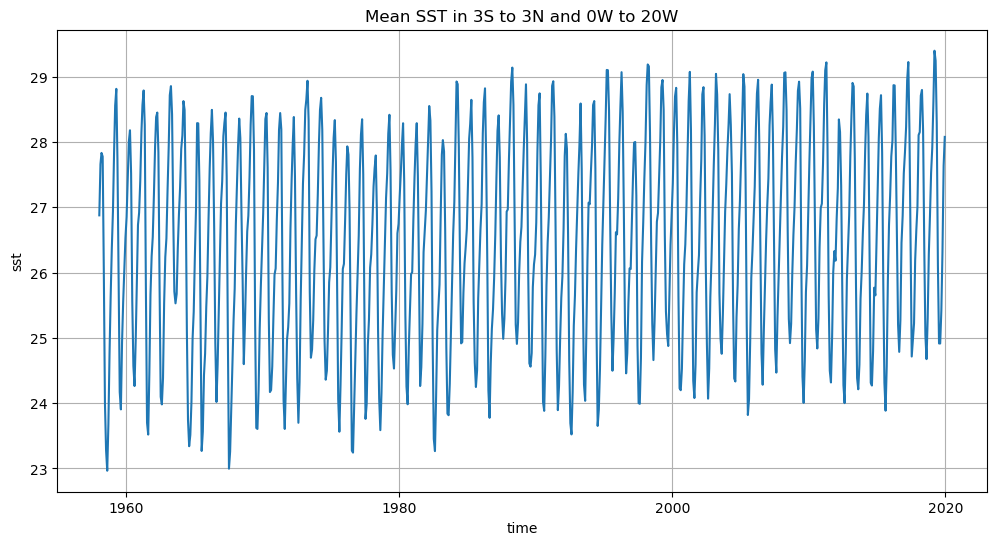

In [5]:
# change time format to cftime for easier indexing
obs_montime_vals = [cftime.DatetimeNoLeap(1870+year, 1+month, 15) for year in range(150) for month in range(12)]
ds['time'] = obs_montime_vals

# select data
SST = ds.sst
boxed_SST = ATLN_box(SST)

# get weight of latitudes
area_weight = np.cos(np.deg2rad(ds.lat))
area_weight.name = "weights"

# weight SSTs
weighted_sst = boxed_SST.weighted(area_weight)

# calculate mean SST in the area
sst_mean = weighted_sst.mean(("lon", "lat"))
sst_mean.plot(figsize=(12, 6))
# sst_mean = sst_mean.where(sst_mean['time.season']=='JJA')

plt.title("Mean SST in 3S to 3N and 0W to 20W")
plt.grid()
plt.show()

## Climatologies and anomalies

In [6]:
# calculate monthly climatologies
climatology = boxed_SST.groupby("time.month").mean()

# calculate monthly anomalies
sst_anom_month = boxed_SST.groupby("time.month") - climatology

In [7]:
# running mean for every three months
ATLN_Index = sst_anom_month.rolling(time=3, center=True).mean()
ATLN_weighted = ATLN_Index.weighted(area_weight).mean(("lat", "lon"), skipna=True)

## Atlantic Niño Index

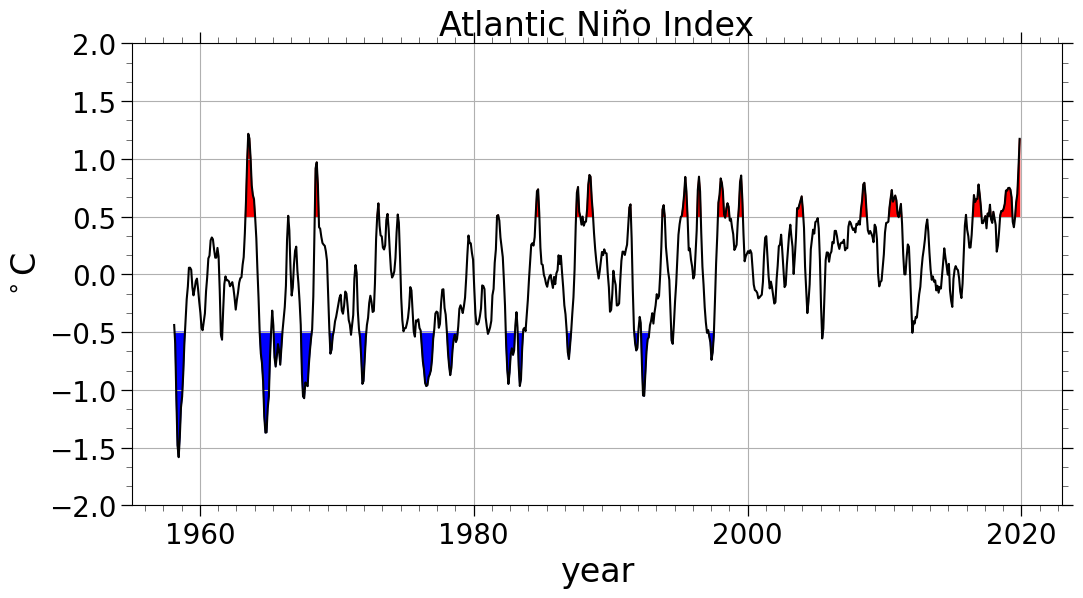

In [8]:
# atlantic niño index plot
fig,ax = plt.subplots(figsize=(12,6))

threshold = 0.5

ax.plot(ATLN_weighted.time, ATLN_weighted, color='black')
gvutil.add_major_minor_ticks(ax, x_minor_per_major=15, y_minor_per_major=3, labelsize=20)

gvutil.set_axes_limits_and_ticks(ax,ylim=(-2., 2.))
ax.fill_between(ATLN_weighted.time.values, ATLN_weighted , y2= -threshold, where=ATLN_weighted < -threshold, color='blue', interpolate=True)
ax.fill_between(ATLN_weighted.time.values, ATLN_weighted, y2= threshold, where=ATLN_weighted > threshold, color='red', interpolate=True)

ax.set_title('Atlantic Niño Index', fontsize=24)#, pad=60.0)
ax.set_ylabel('$^\circ$C', fontsize=24)
ax.set_xlabel('year',fontsize=24)
plt.grid()
plt.show()

## BAD CODE

In [9]:
# # select data in boundaries of interests
# box = sst.sel({'lat' : slice(-3, 3), 'lon' : slice(340, 360)})
# box = box.where(box != 1.e20) # change nan values
# # box = box.where(box['sst'] != 1.e20)

# # TODO: CHANGE TO WEIGHTED AVERAGE WITH COS(LAT)
# # calculate mean through time
# sst_mean = box.mean(dim=['lat', 'lon'])

# # plot
# fig = plt.figure(figsize=(15, 5))
# ax = fig.add_subplot(111)
# # ax.plot(sst.time[1500:1520], sst_mean[1500:1520])
# ax.plot(sst.time, sst_mean)
# plt.grid()
# fig.show()

## JJA Composite Map

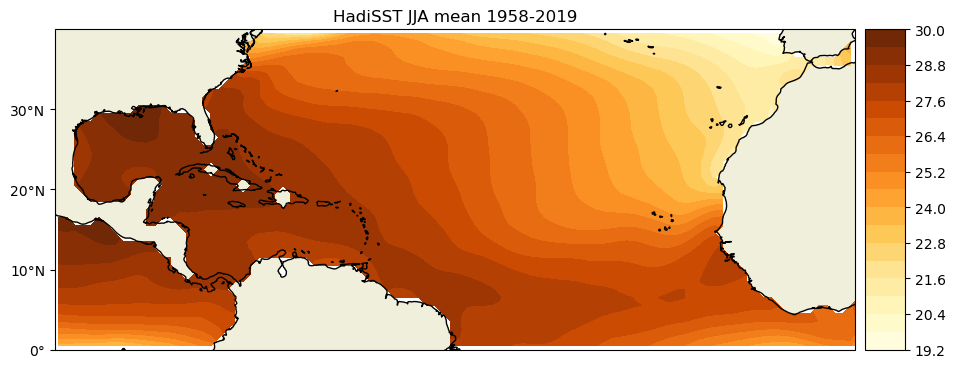

In [10]:
# Select data on map range
box = (260, 360, 0, 40)
SST_boxed = ATLN_box(SST, box)

# select JJA
JJA_SST = SST_boxed.where(SST_boxed['time.season']=='JJA', drop=True)

# climatology
JJA_clim = JJA_SST.mean('time')

# plot
AN_map(JJA_clim, box, "HadiSST JJA mean 1958-2019")

## ATLN+ frequency map?

### What do I want to see?
    Locations and frequency of ATLN+ during JJA. (filled Gray)
    Locations and frequency of ATLN+ during each month. (contour different color for each month and values on line)

    Purpose: If peak month varies we compare differences between GP to ATLN+ peak month in the large ensemble.


In [11]:
# # interpolate to 1.25 to match JRA55 dataset
# lons = np.arange(-1.25, 360, 1.25)
# lats = np.arange(-90, 90, 1.25)
# SST_125 = SST.interp(coords={'lon': lons, 'lat': lats})

# # select sst for the whole box (if its weird change this to just default ATLN box)
# box = (-100, 20, -20, 40)
# boxed_SST = ATLN_box(SST_125, box)

# # do climatologies
# climatology2 = boxed_SST.groupby("time.month").mean(skipna=True)

# # get anomalies
# SST_anom = boxed_SST.groupby("time.month") - climatology2

# # get 3 month running mean of anomalies
# anom_rmean = SST_anom.rolling(time=3, center=True).mean(skipna=True)
# anom_alltime = anom_rmean.mean("time")

# # get ATLN+ frequency
# # 1. count ATLN+ months
# ATLN_p = xr.where(anom_rmean >= 0.5, 1, 0)
# ATLN_py = ATLN_p.sum('time')

# # 2. divide by number of months in dataset
# ATLN_freq = ATLN_py / len(ATLN_p.time)
# # plot composite grays filled with ATLN+ and colored lines with values for each month
# map_box = (-100, 0, -0, 40)
# AN_map(ATLN_freq, box, "ATLN+ frequency from HadiSST 1958-2019")

### Mean anomalies

In [12]:
# AN_map(anom_alltime, box, "HadiSST mean anomalies 1958-2019")

# ATLN+ caused anomalies in ATLN area

In [13]:
# interpolate to 1.25 to match JRA55 dataset
grid = 1.25
lons = np.arange(0.5, 360, grid)
lats = np.arange(-90, 90, grid)
SST_inted = SST.interp(coords={'lon': lons, 'lat': lats}, method='linear')

# define box for plot
box = (-100, 20, -20, 40)
SST_boxed = ATLN_box(SST_inted, box)

# find ATLN+ years
ATLN_Index_JJA = ATLN_Index.where(ATLN_Index['time.season']=='JJA')
ATLN_weighted_JJA = ATLN_Index_JJA.weighted(area_weight).mean(("lat", "lon"))
ATLNp_years = ATLN_weighted_JJA.where(ATLN_weighted_JJA >= 0.5, drop=True).time.dt.year

# climatology
climatology = SST_boxed.groupby("time.month").mean(skipna=True)

# get anomalies
SST_anom = SST_boxed.groupby("time.month") - climatology

# AN Index values
anom_rmean = SST_anom.rolling(time=3, center=True).mean()

### ATLN+ caused anomalies in whole map

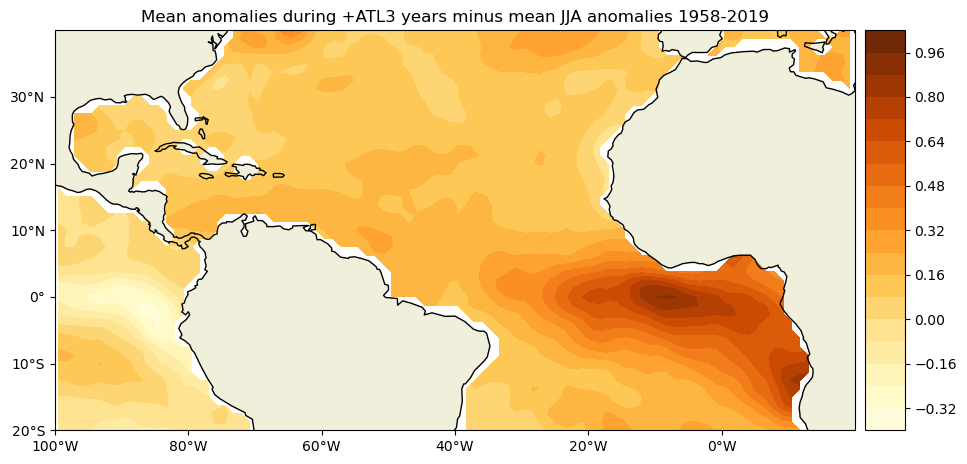

In [14]:
ATLNyears_sst = anom_rmean.where(ATLNp_years, drop=True)
ATLNy_sst_mean = ATLNyears_sst.mean('time')

# select JJA for sst anomaly time mean
JJA_anom = anom_rmean.where(anom_rmean['time.season']=='JJA', drop=True)
JJA_anom_mean = JJA_anom.mean('time')

# mean sst during ATLN_years - mean sst anomaly through JJA
ATLN_anom = ATLNy_sst_mean - JJA_anom_mean
AN_map(ATLN_anom, box, "Mean anomalies during +ATL3 years minus mean JJA anomalies 1958-2019")

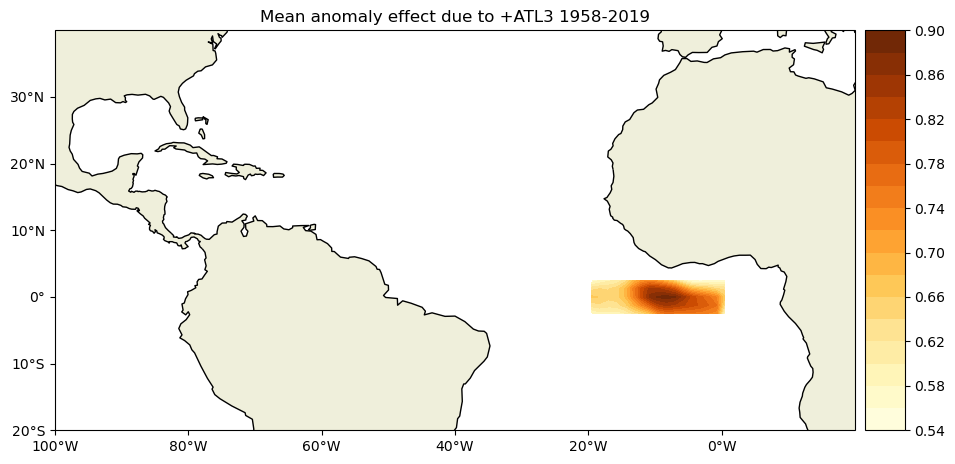

In [15]:
# boxed plot
ATL3 = ATLN_anom.sel(lat=slice(-3, 3), lon=slice(340, 360))
AN_map(ATL3, box, "Mean anomaly effect due to +ATL3 1958-2019")

### Mean anomalies during ATLN+ years minus mean anomalies in JJA during ATLN neutral years???

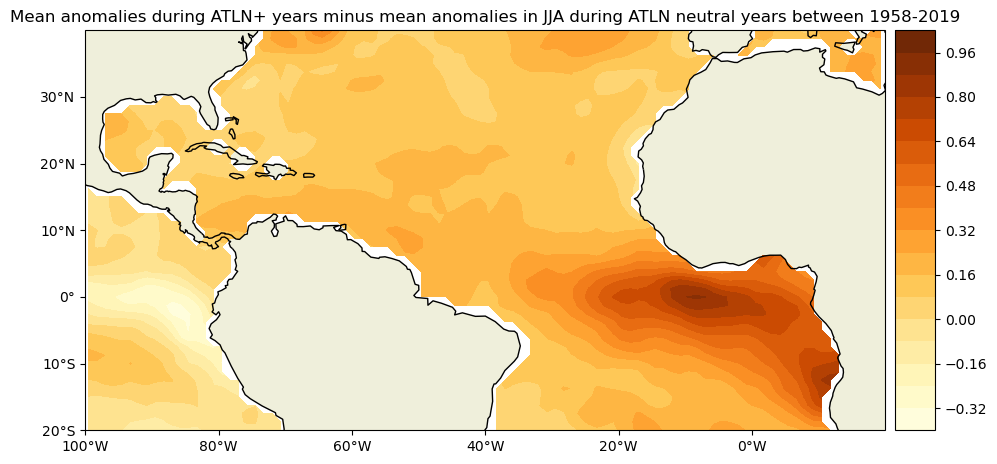

In [16]:
# mean anomalies during neutral years
neutral_years = ATLN_weighted_JJA.where(abs(ATLN_weighted_JJA) <= 0.5).time.dt.year

ATLN_neutral_sst = anom_rmean.where(neutral_years, drop=True)
ATLN_neutral_JJA = ATLN_neutral_sst.where(ATLN_neutral_sst['time.season']=='JJA')
ATLN_neutral_JJA_mean = ATLN_neutral_JJA.mean('time')

# mean anomalies during ATLN+ - mean anomalies in JJA during ATLN neutral years
test = ATLNy_sst_mean - ATLN_neutral_JJA_mean

# plot
AN_map(test, box, "Mean anomalies during ATLN+ years minus mean anomalies in JJA during ATLN neutral years between 1958-2019")

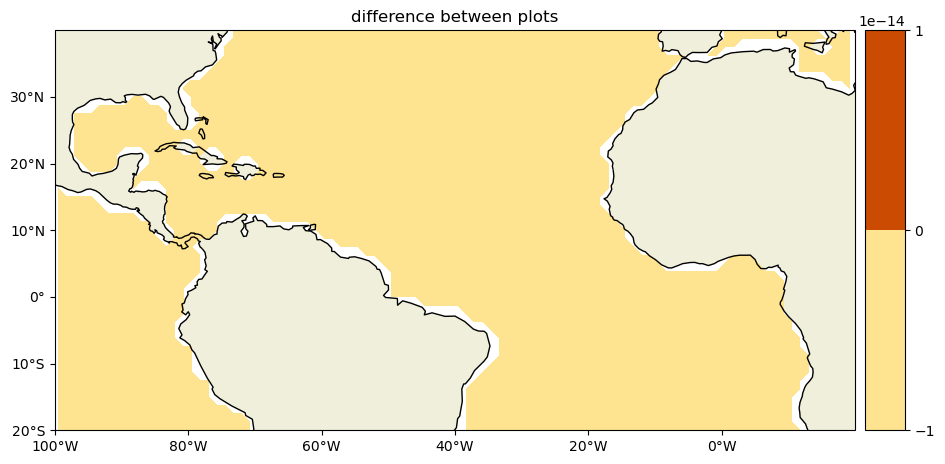

In [17]:
test2 = test - ATLN_anom
AN_map(test2, box, 'difference between plots')

# Export results to NetCDF

In [18]:
climatology # means
SST_anom # anomalies
ATLN_weighted # ATL3 index
ATLN_anom # AN induced anomalies



dims = ('time', 'latitude', 'longitude')
ds = xr.Dataset(data_vars={'sst_mean': (('month', 'latitude', 'longitude'), climatology.values, {'Description': 'HadiSST mean SST each month on each point (climatology)', 'units': 'C'}),
                           'sst_anom': (dims, SST_anom.values, {'Description': "SST anomalies from HadiSST.", 'units': 'C'}),
                           'index': (('time'), ATLN_weighted.values, {'Description': "Atlantic Niño index ATL3.", 'units': 'C'}),
                           'atln_anom': (('latitude', 'longitude'), ATLN_anom.values, {'Description': "Anomalies induced strictly by Atlantic Niño. \
                                                           Mean values during +ATL3 minus mean values during neutral years.", 'units': 'C'})
                          },
               coords={'time': SST_anom.time.values, 'month': climatology.month.values, 'latitude': SST_anom.lat.values, 'longitude': SST_anom.lon.values},
               attrs={'Description': "Results from ATLN_Index.ipynb script based on HadiSST data."}
               )

In [19]:
ds

<xarray.Dataset>
Dimensions:    (month: 12, latitude: 144, longitude: 288, time: 744)
Coordinates:
  * time       (time) object 1958-01-15 00:00:00 ... 2019-12-15 00:00:00
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * latitude   (latitude) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75
  * longitude  (longitude) float64 0.5 1.75 3.0 4.25 ... 355.5 356.8 358.0 359.2
Data variables:
    sst_mean   (month, latitude, longitude) float64 nan nan nan ... -1.8 -1.8
    sst_anom   (time, latitude, longitude) float64 nan nan nan ... nan nan nan
    index      (time) float32 nan -0.4375 -0.5987 -1.085 ... 0.9143 1.174 nan
    atln_anom  (latitude, longitude) float64 nan nan nan nan ... 0.0 0.0 0.0 0.0
Attributes:
    Description:  Results from ATLN_Index.ipynb script based on HadiSST data.

In [20]:
ds.to_netcdf('Data/AN_Index_results.nc')